In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import json
import openai
import random
import os
import collections
import copy
import netgraph
import seaborn as sns
import scipy.stats
import replicate
from utils import get_response, summarize_reasons

MEDIUM_SIZE = 26
SMALL_SIZE = 0.85 * MEDIUM_SIZE
BIGGER_SIZE = 1.5 * MEDIUM_SIZE

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=0.7*SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=0.7*SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def network_growth(n0, temperature, model, environment, role, method='llm', num_common_neighbors=True, cot=False, er=False):

    if method == 'sbm':
        G = nx.stochastic_block_model([n0 // 2, n0 // 2], [[0.5, 0.1], [0.1, 0.5]])
   
        return [G], []

    else:
        if er:
            G = nx.erdos_renyi_graph(n0, 0.1, seed=0)
        else:
            G = nx.stochastic_block_model([n0 // 2, n0 // 2], [[0.5, 0.1], [0.1, 0.5]], seed=0)


    Gs = []
    results = []

    for t in G.nodes():

        if method == 'llm':
            result = select_neighbor(G, t, temperature, num_common_neighbors=num_common_neighbors, model=model, environment=environment, role=role, cot=cot)
            if result:
                v = result['name']
                G.add_edge(t, v)
                results.append(result)
        elif method == 'random':
            v = random.choice(list(set(G.nodes() - set(G.neighbors(t)))))
            G.add_edge(t, v)
            results.append({'name' : v, 'common_friends' : list(set(G.neighbors(v)) & set(G.neighbors(t))), 'reason' : 'random'})
        elif method == 'winner':
            v = None,
            max_common_friends = 0
            for u in G.nodes():
                if u not in G.neighbors(t) and u != t and len(set(G.neighbors(u)) & set(G.neighbors(t))) > max_common_friends:
                    v = u
                    max_common_friends = len(set(G.neighbors(u)) & set(G.neighbors(t)))

            G.add_edge(t, v)
            results.append({'name' : v, 'common_friends' : list(set(G.neighbors(v)) & set(G.neighbors(t))), 'reason' : 'winner'})

        Gs.append(G.copy())

    return Gs, results

def select_neighbor(G, t, temperature, model, environment, role, num_common_neighbors, cot):
    
    candidate_profiles = []
    for v in G.nodes():
        if v != t and v not in G.neighbors(t):
            if num_common_neighbors:
                candidate_profiles.append({'name' : v, 'common_friends' : len(set(G.neighbors(v)) & set(G.neighbors(t)))})
            else:
                candidate_profiles.append({'name' : v, 'friends' : list(G.neighbors(v))})

    if cot: 
        output_format = f"""
    {{
        "reason" : reason for selecting the person,
        "name" : name of the person you selected
    }}
        """
    else:
        output_format = f"""
    {{
        "name" : name of the person you selected,
        "reason" : reason for selecting the person
    }}
        """

    prompt = f"""
    # Task
    {f'You are in a {environment}.' if environment else ''}Your task is to select a person to be {role} with.

    # Input
    The input is a list of dictionaries. 
    Your profile is given below after chevrons:
    <PROFILE>
    {json.dumps({'name' : t, 'friends' : list(G.neighbors(t))})}
    </PROFILE>

    The list of candidate profiles is given below after chevrons:
    <PROFILES>
    {json.dumps(candidate_profiles)}
    </PROFILES>

    # Output
    The output should be given in JSON format with the following structure

    {output_format}

    # Notes
    * The name of the person you selected must be one of the names in the input.
    * Your output must be JSON only.

    ```json
    """   

    for i in range(10):
        try:
            ans = get_response(prompt, temperature=temperature, system_prompt="You are a helpful assistant", model=model)

            try:
                result = json.loads(ans.split('```')[0])
            except:
                result = json.loads(ans.split('```json')[1].split('```')[0])

            if result['name'] in G.nodes():    
                print('NEW EDGE', result)
                return result 
        except Exception as e:
            print(e)
    
def run_network_formation_experiment(n_min, n_max, n_step, num_simulations, outfile, temperatures, method, model, environment=None, role='friends', num_common_neighbors=True, cot=False, er=False):
    """ Run the network formation experiment."""
    saved_scenarios = set()

    if os.path.exists(outfile):
        with open(outfile) as f:
            lines = f.read().splitlines()

            for line in lines:
                scenario = json.loads(line)
                saved_scenarios.add((scenario['n'], scenario['simulation'], scenario['temperature']))

        exit()

    f = open(outfile, 'a+')


    for n in range(n_min, n_max + 1, n_step):
        for i in range(num_simulations):
            for temperature in temperatures:
                if (n, i, temperature) in saved_scenarios:
                    print(f'Skipping simulation for n={n}, i={i}, temperature={temperature}')
                    continue
                else:
                    print(f'Running simulation for n={n}, i={i}, temperature={temperature}')

                    Gs, reasons = network_growth(n, temperature=temperature, method=method, num_common_neighbors=num_common_neighbors, model=model, environment=environment, role=role, cot=cot, er=er)

                    temp = {
                        'n' : n,
                        'temperature' : temperature,
                        'simulation' : i,
                        'graphs' : [nx.to_dict_of_lists(G) for G in Gs],
                        'reasons' : reasons
                    }    

                    f.write(json.dumps(temp) + '\n')            

                if method != 'llm':
                    break

    f.close()

def draw_graph(G, ax, G0=None, use_netgraph=True, er=False):
    if er:
        group_1 = [n for n in G.nodes()]
        group_2 = []
    else:
        group_1 = [n for n in G.nodes() if n < len(G.nodes()) // 2]
        group_2 = [n for n in G.nodes() if n >= len(G.nodes()) // 2]
    
    if not G0:
        G0_edges = set()
    else:
        G0_edges = set(G0.edges())
    G_edges = set(G.edges()) - G0_edges

    G_group_1 = (set(nx.subgraph(G, group_1).edges()) & G_edges) - G0_edges
    G0_group_1 = (set(nx.subgraph(G0, group_1).edges()))
    G_group_2 = (set(nx.subgraph(G, group_2).edges()) & G_edges) - G0_edges
    G0_group_2 = set(nx.subgraph(G0, group_2).edges())
    G_between = G_edges - set(nx.subgraph(G, group_1).edges()) - set(nx.subgraph(G, group_2).edges()) - G0_edges
    G0_between = G0_edges - set(nx.subgraph(G0, group_1).edges()) - set(nx.subgraph(G0, group_2).edges())
    pos = nx.spring_layout(G)

    if not use_netgraph:
       
        node_color = ['#c0392b' if n in group_1 else '#2980b9' for n in G.nodes()]

        if not G0:
            nx.draw(G, pos, ax=ax, node_size=10, width=0.5, node_color=node_color, alpha=0.7, edge_color='#34495e')
        else:
            
            nx.draw_networkx_edges(G, pos, edgelist=G0_edges, width=0.5, alpha=0.5, edge_color='#34495e', ax=ax)
            nx.draw_networkx_edges(G, pos, edgelist=G_between, width=1.0, alpha=1, edge_color='#f1c40f', ax=ax)
            nx.draw_networkx_edges(G, pos, edgelist=G_group_1, width=2, alpha=1, edge_color='#c0392b', ax=ax)
            nx.draw_networkx_edges(G, pos, edgelist=G0_group_1, width=1.0, alpha=0.5, edge_color='#e74c3c', ax=ax)

            nx.draw_networkx_edges(G, pos, edgelist=G_group_2, width=2, alpha=1, edge_color='#2980b9', ax=ax)
            nx.draw_networkx_edges(G, pos, edgelist=G0_group_2, width=1.0, alpha=0.5, edge_color='#3498db', ax=ax)

            nx.draw_networkx_nodes(G, pos, nodelist=list(G.nodes()), node_size=10, node_color=node_color, alpha=0.7, ax=ax)
    else:
        if er:
            node2community = {i: 0 for i in G.nodes()}
        else:
            node2community = {i: 0 if i < len(G.nodes()) // 2 else 1 for i in G.nodes()}
        
        node_color = {i : '#c0392b' if node2community[i] == 0 else  '#2980b9' for i in G.nodes()}

        edge_color = {}
        edge_width = {}
        edge_alpha = {}
        for (u, v) in G.edges():
            if (u, v) in G_group_1:
                edge_color[u, v] = '#c0392b'
            elif (u, v) in G_group_2:
                edge_color[u, v] = '#2980b9'
            elif (u, v) in G0_group_1:
                edge_color[u, v] = '#e74c3c'
            elif (u, v) in G0_group_2:
                edge_color[u, v] = '#3498db'
            elif (u, v) in G_between:
                edge_color[u, v] = '#f1c40f'
            else:
                edge_color[u, v] = '#bdc3c7'

            if (u, v) in G_group_1 or (u, v) in G_group_2 or (u, v) in G_between:
                edge_width[u, v] = 2
                edge_alpha[u, v] = 1
            else:
                edge_width[u, v] = 1
                edge_alpha[u, v] = 0.5

        # netgraph.Graph(G, node_layout='community', node_color=node_color, node_layout_kwargs=dict(node_to_community=node2community), node_size=2.5, edge_color=edge_color, edge_layout='bundled', edge_layout_kwargs=dict(k=2000), ax=ax)
        netgraph.Graph(G, node_layout=pos, node_color=node_color, node_layout_kwargs=dict(node_to_community=node2community), node_size=2.5, edge_color=edge_color, edge_width=edge_width, edge_alpha=edge_alpha, ax=ax)


    ax.set_axis_off()

def prob_edge_within_community(G, G0, er=False):
    if er:
        group_1 = [n for n in G.nodes()]
        group_2 = []
    else:
        group_1 = [n for n in G.nodes() if n < len(G.nodes()) // 2]
        group_2 = [n for n in G.nodes() if n >= len(G.nodes()) // 2]
    
    G0_edges = set(G0.edges())

    G_edges = set(G.edges()) - G0_edges

    G_between = G_edges - set(nx.subgraph(G, group_1).edges()) - set(nx.subgraph(G, group_2).edges()) - G0_edges

    try:
        return 1 - len(G_between) / (1e-1 + len(G_edges))
    except:
        return 0

def analyze_experiments(filename, num_common_neighbors=True, er=False, sfx=''):

    suffix = os.path.split(os.path.splitext(filename)[0])[-1]

    with open(filename) as f:
        lines = f.read().splitlines()

    data = []

    for line in lines:
        data.append(json.loads(line))

    transitivities = collections.defaultdict(list)
    algebraic_connectivities = collections.defaultdict(list)
    probabilities_of_edge_within_community = collections.defaultdict(list)
    # partition_qualitys = collections.defaultdict(list)

    final_graphs = collections.defaultdict(list)

    for d in data:
        Gs = []
        for i, graph in enumerate(d['graphs']):
            G = nx.Graph()

            for k, v in graph.items():
                k = int(k)
                G.add_node(k)
                for n in v:
                    G.add_edge(k, n)

            G.remove_edges_from(nx.selfloop_edges(G))

            if i > 0:
                print('new edge', set(G.edges()) - set(Gs[0].edges()))

            Gs.append(G)

        # fig, ax = plt.subplots(1, 4, figsize=(20, 5))

        # fig.suptitle(f'Temperature = {d["temperature"]}')

        # for i, t in enumerate([0, len(Gs) // 2, len(Gs) - 1]):
        #     G = Gs[t]
        #     ax[i].set_title(f'$t = {t}$')
        #     draw_graph(G, ax=ax[i], G0=Gs[0])

            # print(d['reasons'])

        if er:
            group_1 = [n for n in G.nodes()]
            group_2 = []
        else:
            group_1 = [n for n in G.nodes() if n < len(G.nodes()) // 2]
            group_2 = [n for n in G.nodes() if n >= len(G.nodes()) // 2]


        final_graphs[d['n'], d['temperature']].append((Gs[-1], Gs[0]))

        initial_transitivity = nx.transitivity(Gs[0])

        transitivity = [nx.transitivity(G) - initial_transitivity for G in Gs]

        algebraic_connectivity = [nx.algebraic_connectivity(G) for G in Gs]

        probability_of_edge_within_community = [prob_edge_within_community(G, Gs[0], er=er) for G in Gs[1:]]

        # partition_quality = [nx.community.partition_quality(G, communities)[0] for G in Gs]

        # ax[-1].set_title('Metrics')
        # ax[-1].plot(transitivity, label='Marginal Transitivity', color='#c0392b')

        # ax_y = ax[-1].twinx()

        # ax_y.plot(algebraic_connectivity, label='Algebraic Connectivity', color='#2980b9')
        # ax[-1].set_xlabel('t')
        # ax[-1].set_ylabel('Transitivity', color='#c0392b')
        # ax_y.set_ylabel('Algebraic Connectivity', color='#2980b9')

        transitivities[d['n'], d['temperature']].append(transitivity)
        algebraic_connectivities[d['n'], d['temperature']].append(algebraic_connectivity)
        probabilities_of_edge_within_community[d['n'], d['temperature']].append(probability_of_edge_within_community)
        # partition_qualitys[d['n'], d['temperature']].append(partition_quality)

        # fig.tight_layout()
        # fig.savefig(f'figures/principle_2/{suffix}_{d["n"]}_{d["simulation"]}_{d["temperature"]}{"_neighbors" if not num_common_neighbors else ""}.png', dpi=300)

    palette = ['#e67e22', '#f1c40f', '#7f8c8d', '#c0392b', '#2980b9', '#34495e']


    # fig, ax = plt.subplots(4, len(transitivities), figsize=(5 * len(transitivities), 10), squeeze=False, sharey='row')

    if er:
        fig_final, ax_final = plt.subplots(1, len(final_graphs) + 1, figsize=(5 * (1 + len(final_graphs)), 5), squeeze=False)

        ax_final[0, -1].spines[['right', 'top']].set_visible(False)
    else:

        fig_final, ax_final = plt.subplots(1, len(final_graphs) + 2, figsize=(5 * (2 + len(final_graphs)), 5), squeeze=False, gridspec_kw={'width_ratios': [1] * len(final_graphs) + [0.5, 0.5]})

        ax_final[0, -1].spines[['right', 'top']].set_visible(False)
        ax_final[0, -2].spines[['right', 'top']].set_visible(False)



    for i, (k, v) in enumerate(sorted(final_graphs.items())):
        G, G0 = v[0]
        draw_graph(G, ax=ax_final[0, i], G0=G0, er=er)

        ax_final[0, i].set_title(f'Temperature = {k[1]}')


    if er:
        ax_final[0, -1].set_ylabel('Marginal Transitivity')
        ax_final[0, -1].set_xticks([])

    else:
        ax_final[0, -2].set_ylabel('Marginal Transitivity')
        ax_final[0, -2].set_xticks([])

            
        ax_final[0, -1].set_ylabel('Pr. of Edge within Community')
        ax_final[0, -1].set_xticks([])

    for i, (k, c) in enumerate(zip(sorted(transitivities.keys()), palette)):
        v = transitivities[k]
        v = np.array(v)

        mean = v.mean(axis=0)
        std = v.std(axis=0)

        ci = 1.96 * std / np.sqrt(len(v))

        if er:
            ax_final[0, -1].bar(i, mean[-1], color=palette[i], alpha=0.6, label='Temp = ' + str(k[1]))
            ax_final[0, -1].errorbar(i, mean[-1], yerr=ci[-1], color='black', alpha=1)
        else:
            ax_final[0, -2].bar(i, mean[-1], color=palette[i], alpha=0.6, label='Temp = ' + str(k[1]))
            ax_final[0, -2].errorbar(i, mean[-1], yerr=ci[-1], color='black', alpha=1)


    if not er:
        for i, (k, c) in enumerate(zip(sorted(probabilities_of_edge_within_community.keys()), palette)):
            v = probabilities_of_edge_within_community[k]
            v = np.array(v)

            mean = v.mean(axis=0)
            std = v.std(axis=0)

            ci = 1.96 * std / np.sqrt(len(v))

            
            ax_final[0, -1].bar(i, mean[-1], color=palette[i], alpha=0.5, label='Temp = ' + str(k[1]))
            ax_final[0, -1].errorbar(i, mean[-1], yerr=ci[-1], color='black', alpha=0.5)



    # Null models
    transitivities_null = { 'random' : collections.defaultdict(list), 'winner' : collections.defaultdict(list), 'sbm' : collections.defaultdict(list) }
    algebraic_connectivities_null = { 'random' : collections.defaultdict(list), 'winner' : collections.defaultdict(list), 'sbm' : collections.defaultdict(list) }
    probabilities_of_edge_within_community_null = { 'random' : collections.defaultdict(list), 'winner' : collections.defaultdict(list), 'sbm' : collections.defaultdict(list) }

    for d in data:
        for method in ['random']:
            Gs, _ = network_growth(d['n'], d['temperature'], method=method, model='gpt-3.5-turbo', environment=None, role='friends', num_common_neighbors=num_common_neighbors, cot=False, er=er)

            initial_transitivity = nx.transitivity(Gs[0])

            transitivity = [nx.transitivity(G) - initial_transitivity for G in Gs]

            transitivities_null[method][d['n'], d['temperature']].append(transitivity)


            algebraic_connectivity = [nx.algebraic_connectivity(G) for G in Gs]

            algebraic_connectivities_null[method][d['n'], d['temperature']].append(algebraic_connectivity)

            if er:
                group_1 = [n for n in Gs[0].nodes()]
                group_2 = []
            else:
                group_1 = [n for n in G.nodes() if n < len(G.nodes()) // 2]
                group_2 = [n for n in G.nodes() if n >= len(G.nodes()) // 2]

            communities = [group_1, group_2]

            probability_of_edge_within_community = [prob_edge_within_community(G, Gs[0], er=er) for G in Gs[1:]]

            probabilities_of_edge_within_community_null[method][d['n'], d['temperature']].append(probability_of_edge_within_community)

    

    for j, method in enumerate(['random']):
        for i, (k, v) in enumerate(transitivities_null[method].items()):
            v = np.array(v)

            mean = v.mean(axis=0)
            std = v.std(axis=0)

            ci = 1.96 * std / np.sqrt(len(v))

            if i == 0:

                if method == 'random':
                    transitivity_temp = mean.mean()
                    print('Transitivity null: ', transitivity_temp)

        
            if i == 0:
                if er:
                    ax_final[0, -1].bar(j + 3, mean[-1], color=palette[j+3], alpha=0.6, label=method.capitalize())
                    ax_final[0, -1].errorbar(j + 3, mean[-1], yerr=ci[-1], color='black', alpha=1)
                else:
                    ax_final[0, -2].bar(j + 3, mean[-1], color=palette[j+3], alpha=0.6, label=method.capitalize())
                    ax_final[0, -2].errorbar(j + 3, mean[-1], yerr=ci[-1], color='black', alpha=1)
            

            print('Transitivity T-test', k, method, scipy.stats.ttest_ind([x[-1] for x in transitivities[k]], [x[-1] for x in transitivities_null[method][k]], equal_var=False))

        for i, (k, v) in enumerate(algebraic_connectivities_null[method].items()):
            v = np.array(v)

            mean = v.mean(axis=0)
            std = v.std(axis=0)

            ci = 1.96 * std / np.sqrt(len(v))

            # print('Algebraic Connectivity T-test', k, method, scipy.stats.ttest_ind([x[-1] for x in algebraic_connectivities[k]], [x[-1] for x in algebraic_connectivities_null[method][k]], equal_var=False))

        for i, (k, v) in enumerate(probabilities_of_edge_within_community_null[method].items()):
            

            v = np.array(v)

            mean = v.mean(axis=0)
            std = v.std(axis=0)

            ci = 1.96 * std / np.sqrt(len(v))

            # ax[1, i].plot(mean, color='#c0392b' if method == 'random' else '#34495e', linestyle='--' if method == 'random' else ':', label=method.capitalize())
            # ax[1, i].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color='#c0392b' if method == 'random' else '#34495e')
            if i == 0:
                # ax_combined[0, 2].plot(mean, color='#c0392b' if method == 'random' else '#34495e', linestyle='--' if method == 'random' else ':')
                # ax_combined[0, 2].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color='#c0392b' if method == 'random' else '#34495e', hatch='||')

                if method == 'random':
                    probability_temp = mean.mean()
                    print('Probability null: ', probability_temp)

            if i == 0:
                if not er:
                    ax_final[0, -1].bar(j + 3, mean[-1], color=palette[j+3], alpha=0.6, label=method.capitalize())
                    ax_final[0, -1].errorbar(j + 3, mean[-1], yerr=ci[-1], color='black', alpha=1)


            print('Probability of edge within community T-test', k, method, scipy.stats.ttest_ind([x[-1] for x in probabilities_of_edge_within_community[k]], [x[-1] for x in probabilities_of_edge_within_community_null[method][k]], equal_var=False))

        # for i, (k, v) in enumerate(probabilities_of_edge_within_community_null[method].items()):
        #     v = np.array(v)

        #     mean = v.mean(axis=0)
        #     std = v.std(axis=0)

        #     ci = 1.96 * std / np.sqrt(len(v))

        #     ax[1, i].plot(mean, color='#c0392b' if method == 'random' else '#34495e', linestyle='--' if method == 'random' else ':', label=method.capitalize())
        #     ax[1, i].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color='#c0392b' if method == 'random' else '#34495e')
        #     if i == 0:
        #         ax_combined[0, 3].plot(mean, color='#c0392b' if method == 'random' else '#34495e', linestyle='--' if method == 'random' else ':')
        #         ax_combined[0, 3].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color='#c0392b' if method == 'random' else '#34495e', hatch='||')

        #     if i == 0:
        #         ax_final[0, -2].bar(j + 3, mean[-1], color=palette[j+3], alpha=0.6, label=method.capitalize())
        #         ax_final[0, -2].errorbar(j + 3, mean[-1], yerr=ci[-1], color='black', alpha=1)

        #     print('Partition Quality T-test', k, method, scipy.stats.ttest_ind([x[-1] for x in partition_qualitys[k]], [x[-1] for x in partition_qualitys_null[method][k]], equal_var=False))

    ax_final[0, -1].legend(bbox_to_anchor=(1, 0.5), loc='center left', frameon=False)

    # ax[0, 0].legend(loc='upper left')
    # ax[1, 0].legend(loc='upper left')

    # ax_combined[0, 0].legend(loc='upper left')
    # ax_combined[0, 1].legend(loc='upper left')

    # fig_combined.tight_layout()

    # fig.tight_layout()

    # fig.savefig(f'figures/principle_2/{suffix}_overall{"_neighbors" if not num_common_neighbors else ""}.png', dpi=300)

    # fig_combined.savefig(f'figures/principle_2/{suffix}_overall_combined{"_neighbors" if not num_common_neighbors else ""}.png', dpi=300)
     

    fig_final.tight_layout()

    fig_final.savefig(f'figures/principle_2/{suffix}_final{"_neighbors" if not num_common_neighbors else ""}{sfx}.png', dpi=300)

    return transitivity_temp, probability_temp

def get_table(filenames, sfx='', environments=True, transitivity_null=-1, probability_null=-1, er=False):

    records = []

    num_graphs = 0

    for filename in filenames:
        print(filename)
        suffix = os.path.split(os.path.splitext(filename)[0])[-1]
        suffix = suffix.split('+')

        if len(suffix) == 3:
            model = suffix[-2]
            environment = suffix[-1]
        elif len(suffix) == 2:
            model = suffix[-1]
            environment = 'Baseline'
        else:
            environment = 'Baseline'

        with open(filename) as f:
            lines = f.read().splitlines()

        data = []

        for line in lines:
            data.append(json.loads(line))

        for d in data:
            Gs = []

            for i, graph in enumerate(d['graphs']):
                G = nx.Graph()

                for k, v in graph.items():
                    k = int(k)
                    G.add_node(k)
                    for n in v:
                        G.add_edge(k, n)

                if i == 0:
                    top_common_neighbors = np.zeros(len(G.nodes()))
                    total = 0
                else:
                    new_edge =  set(G.edges()) - set(Gs[-1].edges())
                    if len(new_edge) == 0:
                        continue

                    new_edge = new_edge.pop()

                    u, v = new_edge

                    common_neighbors_u = [len(set(G.neighbors(u)) & set(G.neighbors(n))) for n in G.nodes() if n != u]

                    # find what position the new edge is in the sorted list of common neighbors
                    try:
                        pos = np.argsort(common_neighbors_u)[::-1].tolist().index(v)
                        top_common_neighbors[pos] += 1
                        total += 1
                    except:
                        pass

                G.remove_edges_from(nx.selfloop_edges(G))

                Gs.append(G)

            top_common_neighbors /= total

            top_common_neighbors = np.cumsum(top_common_neighbors)
            top_common_neighbors = np.insert(top_common_neighbors, 0, 0)


            initial_transitivity = nx.transitivity(Gs[0])
            final_transitivity = nx.transitivity(Gs[-1])
            marginal_transitivity = final_transitivity - initial_transitivity
            final_probability_of_edge_within_community = prob_edge_within_community(Gs[-1], Gs[1], er=er)

            record = {
                'Model' : model,
                'Environment' : environment,
                'Temperature' : d['temperature'],
                'Marginal Transitivity' : marginal_transitivity,
                # 'Algebraic Connectivity' : final_algebraic_connectivity,
                'Prob. of Edge within Community' : final_probability_of_edge_within_community,
                'Probability of Connecting to Top-$k$' : top_common_neighbors,
                'Top-$k$' : np.arange(0, len(top_common_neighbors)) / len(top_common_neighbors)
            }

            records.append(record)

        

    df = pd.DataFrame(records)

    rename_models = {
        'gpt-3.5-turbo' : 'GPT-3.5',
        'gpt-4o-mini' : 'GPT-4 Mini',
        'meta-meta-llama-3-70b-instruct' : 'LLAMA-3',
        'claude-3-5-sonnet-20240620' : 'Claude 3.5',
        'gpt-3.5-turbo_cot' : 'GPT-3.5',
        'gpt-4o-mini_cot' : 'GPT-4 Mini',
        'meta-meta-llama-3-70b-instruct_cot' : 'LLAMA-3',
        'claude-3-5-sonnet-20240620_cot' : 'Claude 3.5'
    }

    rename_env = {
        'school' : 'School',
        'work' : 'Work',
        'community' : 'Community',
        'school_cot' : 'School',
        'work_cot' : 'Work',
        'community_cot' : 'Community',
    }


    ncols = 2 + int(environments)

    df['Model'] = df['Model'].apply(lambda x: rename_models.get(x, x))
    df['Environment'] = df['Environment'].apply(lambda x: rename_env.get(x, x))

    df_model = df.query('Environment == "Baseline" and Temperature == 0.5')
    df_environment = df.query('Model == "GPT-4 Mini"')

    df_temperature = df.query('Model == "GPT-4 Mini" and Environment == "Baseline"')

    if er:
        fig, ax = plt.subplots(1, ncols, figsize=(5 * ncols, 5), squeeze=False)
    else:
        fig, ax = plt.subplots(2, ncols, figsize=(5 * ncols, 10))
    
    sc_model = sns.barplot(data=df_model, y='Marginal Transitivity', x='Model', ax=ax[0, 0], palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9'])

    sc_temperature = sns.barplot(data=df_temperature, y='Marginal Transitivity', x='Temperature', ax=ax[0, 1], palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9'])
    
    ax[0, 0].set_ylabel('D')

    


    if not er:
        ax[0, 0].set_xticks([])
        ax[0, 1].set_xticks([])
    
        ax[0, 0].set_xlabel('')
        ax[0, 1].set_xlabel('')

        ax[0, 1].get_yaxis().set_visible(False)

    if er:
        ax[0, 0].set_ylim(0, 0.25)
        ax[0, 1].set_ylim(0, 0.25)
    else:
        ax[0, 0].set_ylim(0, 0.1)
        ax[0, 1].set_ylim(0, 0.1)



    if environments:
        sc_environment = sns.barplot(data=df_environment, y='Marginal Transitivity', x='Environment', ax=ax[0, ncols-1], palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9'])
        ax[0, 2].get_yaxis().set_visible(False)
        ax[0, 2].set_xlabel('')
        if er:
            ax[0, 2].set_ylim(0, 0.25)
        else:
            ax[0, 2].set_ylim(0, 0.1)
            ax[0, 2].set_xticks([])


    if not er:
        sc_model = sns.barplot(data=df_model, y='Prob. of Edge within Community', x='Model', ax=ax[1, 0], palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9'])
        sc_temperature = sns.barplot(data=df_temperature, y='Prob. of Edge within Community', x='Temperature', ax=ax[1, 1], palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9'])

    if transitivity_null != -1:
        ax[0, 0].axhline(y=transitivity_null, color='black', linestyle='--')
        ax[0, 1].axhline(y=transitivity_null, color='black', linestyle='--')
        ax[0, 2].axhline(y=transitivity_null, color='black', linestyle='--')

    if probability_null != -1 and not er:
        ax[1, 0].axhline(y=probability_null, color='black', linestyle='--')
        ax[1, 1].axhline(y=probability_null, color='black', linestyle='--')
        ax[1, 2].axhline(y=probability_null, color='black', linestyle='--')

    sc_model.set_xticklabels(sc_model.get_xticklabels(), rotation=90)
    sc_temperature.set_xticklabels(sc_temperature.get_xticklabels(), rotation=90)

    if er and environments:
        sc_environment.set_xticklabels(sc_environment.get_xticklabels(), rotation=90)
        
    ax[0, 0].set_title('Model')
    ax[0, 1].set_title('Temperature')

    if not er:
        ax[1, 0].set_ylabel('$\\hat p$')
        ax[1, 1].set_ylabel('')

        ax[1, 0].set_xlabel('')
        ax[1, 1].set_xlabel('')


        ax[1, 1].get_yaxis().set_visible(False)

        ax[1, 0].set_ylim(0, 1)
        ax[1, 1].set_ylim(0, 1)
        
    if environments and not er:
        sc_environment = sns.barplot(data=df_environment, y='Prob. of Edge within Community', x='Environment', ax=ax[1, 2], palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9'])
        sc_environment.set_xticklabels(sc_environment.get_xticklabels(), rotation=90)
        ax[1, 2].set_ylim(0, 1)
        ax[1, 2].get_yaxis().set_visible(False)
        ax[1, 2].set_xlabel('')
        ax[1, 2].set_ylabel('')
        ax[1, 2].spines[['right', 'top']].set_visible(False)
        

    ax[0, 0].spines[['right', 'top']].set_visible(False)
    ax[0, 1].spines[['right', 'top']].set_visible(False)
    ax[0, 2].spines[['right', 'top']].set_visible(False)
    ax[0, 2].set_title('Environment')


    ax[0, 1].set_ylabel('')
    ax[0, 2].set_ylabel('')
    ax[0, 0].set_xlabel('')
    ax[0, 1].set_xlabel('')
    ax[0, 2].set_xlabel('')


    if not er:
        ax[1, 0].spines[['right', 'top']].set_visible(False)
        ax[1, 1].spines[['right', 'top']].set_visible(False)

    fig.savefig(f'figures/triadic_closure{sfx}.png', dpi=300, bbox_inches='tight')

    fig, ax = plt.subplots(1, ncols, figsize=(5 * ncols, 5))

    palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9']

    fig.suptitle('Probability of Connecting to Top-$k$ Common Neighbors', fontsize=SMALL_SIZE)

    breakpoints_arr = [('top', np.array([0.1, 0.2, 0.3, 0.4, 0.5])), ('all', np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]))]

    for label, breakpoints in breakpoints_arr:
        breakpoint_max = np.max(breakpoints)
        breakpoint_min = np.min(breakpoints)

        for i in range(len(ax)):
            ax[i].plot([0, 100 * breakpoint_max], [0, breakpoint_max], color='black', linestyle='--')
            ax[i].set_xlim(100 * breakpoint_min, 100 * breakpoint_max)

        for i, model in enumerate(df_model['Model'].unique()):
            temp = df_model[df_model['Model'] == model]

            n = len(temp['Top-$k$'].values[0])

            indices = np.array([int(x * n) for x in breakpoints])

            color = palette[i]
            linewidth = 1

            if model == 'GPT-4 Mini' and df_model['Environment'].values[i] == 'Baseline' and df_model['Temperature'].values[i] == 0.5:
                color = '#34495e'
                linewidth = 3

            ax[0].plot(100 * temp['Top-$k$'].values[0][indices], temp['Probability of Connecting to Top-$k$'].values.mean(0)[indices], label=model, color=color, linewidth=linewidth, marker='x')

        

        ax[0].set_title('Model')
        ax[0].set_xlabel('Top-$k$ (%)')
        # ax[0].set_xscale('log')
        # ax[0].set_yscale('log')
        ax[0].set_ylabel('')
        
        ax[0].legend(fontsize=0.7*SMALL_SIZE, loc='upper left')

        for i, temperature in enumerate(df_temperature['Temperature'].unique()):
            temp = df_temperature[df_temperature['Temperature'] == temperature]

            n = len(temp['Top-$k$'].values[0])

            indices = np.array([int(x * n) for x in breakpoints])

            color = palette[i]
            linewidth = 1

            if temperature == 0.5 and df_temperature['Model'].values[i] == 'GPT-4 Mini' and df_temperature['Environment'].values[i] == 'Baseline':
                color = '#34495e'
                linewidth = 3
                

            ax[1].plot(100 * temp['Top-$k$'].values[0][indices], temp['Probability of Connecting to Top-$k$'].values.mean(0)[indices], label=f'{temperature}', color=color, linewidth=linewidth, marker='x')


        ax[1].set_title('Temperature')
        ax[1].set_xlabel('Top-$k$ (%)')
        # ax[1].set_xscale('log')
        # ax[1].set_yscale('log')
        ax[1].set_ylabel('')

        ax[1].legend(fontsize=0.7*SMALL_SIZE, loc='upper left')

        if environments:

            for i, environment in enumerate(df_environment['Environment'].unique()):
                temp = df_environment[df_environment['Environment'] == environment]

                n = len(temp['Top-$k$'].values[0])

                indices = np.array([int(x * n) for x in breakpoints])

                color = palette[i]
                linewidth = 1

                if environment == 'Baseline' and df_environment['Model'].values[i] == 'GPT-4 Mini' and df_environment['Temperature'].values[i] == 0.5:
                    color = '#34495e'
                    linewidth = 3        
                    ax[2].plot(100 * temp['Top-$k$'].values[0][indices], df_model[df_model['Model'] == 'GPT-4 Mini']['Probability of Connecting to Top-$k$'].values.mean(0)[indices], label='GPT-4 Mini', color=color, linewidth=linewidth, marker='x')

                else:
                    ax[2].plot(100 * temp['Top-$k$'].values[0][indices], temp['Probability of Connecting to Top-$k$'].values.mean(0)[indices], label=environment, color=color, linewidth=linewidth, marker='x')


            ax[2].set_title('Environment')
            ax[2].set_xlabel('Top-$k$ (%)')
        
            ax[2].set_ylabel('')
            ax[2].legend(fontsize=0.7*SMALL_SIZE, loc='upper left')
            ax[2].set_ylim(0, 1)
            ax[2].get_yaxis().set_visible(False)
            ax[2].spines[['right', 'top']].set_visible(False)


        ax[0].set_ylim(0, 1)
        ax[1].set_ylim(0, 1)

        # hide y axis numbers
        ax[1].get_yaxis().set_visible(False)

        ax[0].spines[['right', 'top']].set_visible(False)
        ax[1].spines[['right', 'top']].set_visible(False)

        fig.tight_layout()

                        
        fig.savefig(f'figures/top_kcommon{label}_{sfx}.png', dpi=300, bbox_inches='tight')




Skipping simulation for n=50, i=0, temperature=0.5
Skipping simulation for n=50, i=1, temperature=0.5
Skipping simulation for n=50, i=2, temperature=0.5
Skipping simulation for n=50, i=3, temperature=0.5
Skipping simulation for n=50, i=4, temperature=0.5
Skipping simulation for n=50, i=5, temperature=0.5
Skipping simulation for n=50, i=6, temperature=0.5
Skipping simulation for n=50, i=7, temperature=0.5
Skipping simulation for n=50, i=8, temperature=0.5
Skipping simulation for n=50, i=9, temperature=0.5
Skipping simulation for n=50, i=0, temperature=0.5
Skipping simulation for n=50, i=1, temperature=0.5
Skipping simulation for n=50, i=2, temperature=0.5
Skipping simulation for n=50, i=3, temperature=0.5
Skipping simulation for n=50, i=4, temperature=0.5
Skipping simulation for n=50, i=5, temperature=0.5
Skipping simulation for n=50, i=6, temperature=0.5
Skipping simulation for n=50, i=7, temperature=0.5
Skipping simulation for n=50, i=8, temperature=0.5
Skipping simulation for n=50, i

/Users/marios/miniconda3/lib/python3.12/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


Transitivity null:  -0.0017288098106399575
Transitivity T-test (50, 0.5) random TtestResult(statistic=np.float64(19.781695131356276), pvalue=np.float64(4.959824825721471e-13), df=np.float64(16.714545050754303))
Transitivity T-test (50, 1.0) random TtestResult(statistic=np.float64(9.948916683337867), pvalue=np.float64(4.6650788872339046e-07), df=np.float64(11.704394953840449))
Transitivity T-test (50, 1.5) random TtestResult(statistic=np.float64(11.162947149129371), pvalue=np.float64(1.1509596799223409e-08), df=np.float64(15.003406081315422))
Algebraic Connectivity T-test (50, 0.5) random TtestResult(statistic=np.float64(-14.805147087287835), pvalue=np.float64(3.2059263396420545e-10), df=np.float64(14.663082092554648))
Algebraic Connectivity T-test (50, 1.0) random TtestResult(statistic=np.float64(-7.084415994693363), pvalue=np.float64(3.510710564593215e-06), df=np.float64(15.154887216363315))
Algebraic Connectivity T-test (50, 1.5) random TtestResult(statistic=np.float64(-6.78254034160

/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_37307/2747599785.py:709: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sc_model = sns.barplot(data=df_model, y='Marginal Transitivity', x='Model', ax=ax[0, 0], palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9'])
/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_37307/2747599785.py:709: UserWarning: The palette list has more values (7) than needed (4), which may not be intended.
  sc_model = sns.barplot(data=df_model, y='Marginal Transitivity', x='Model', ax=ax[0, 0], palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9'])
/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_37307/2747599785.py:711: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the

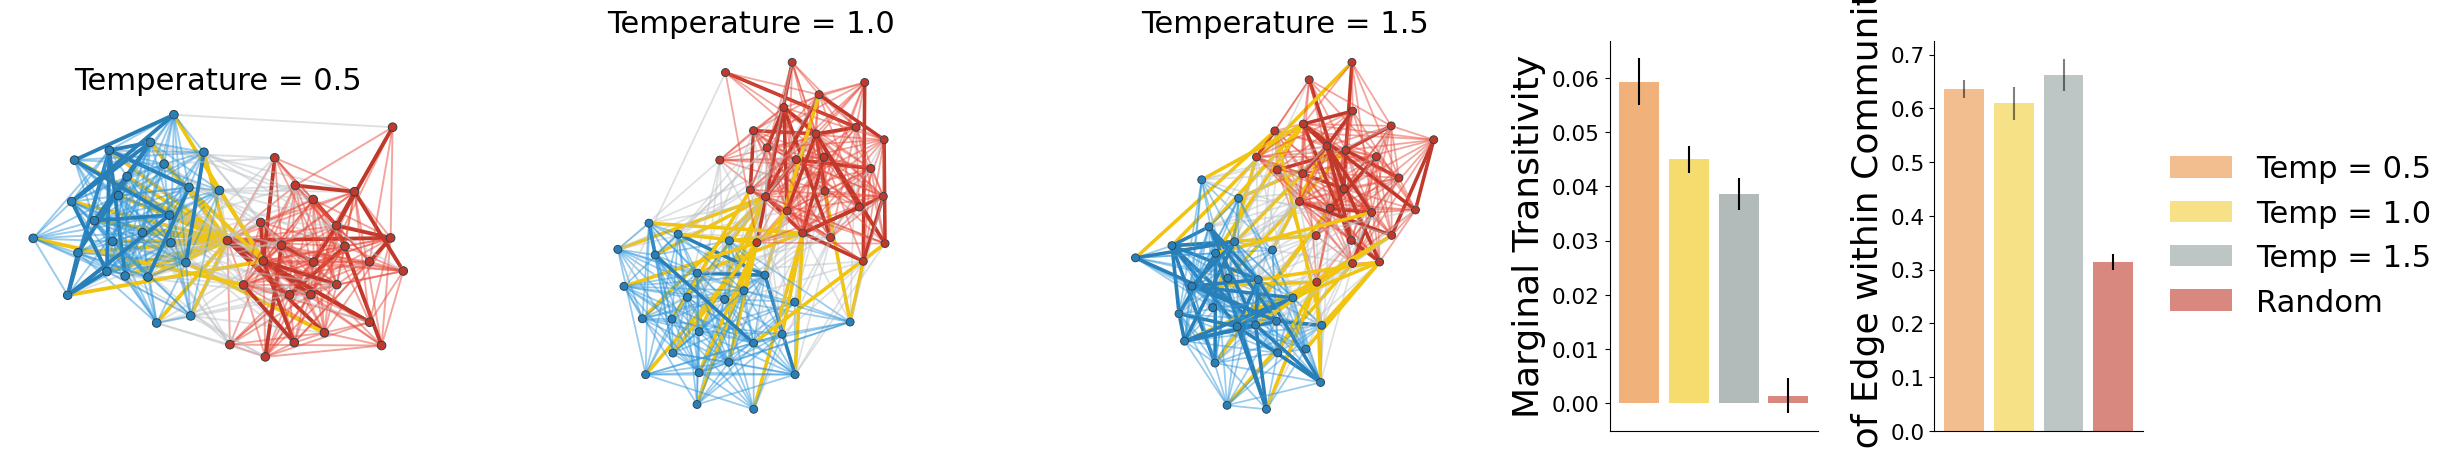

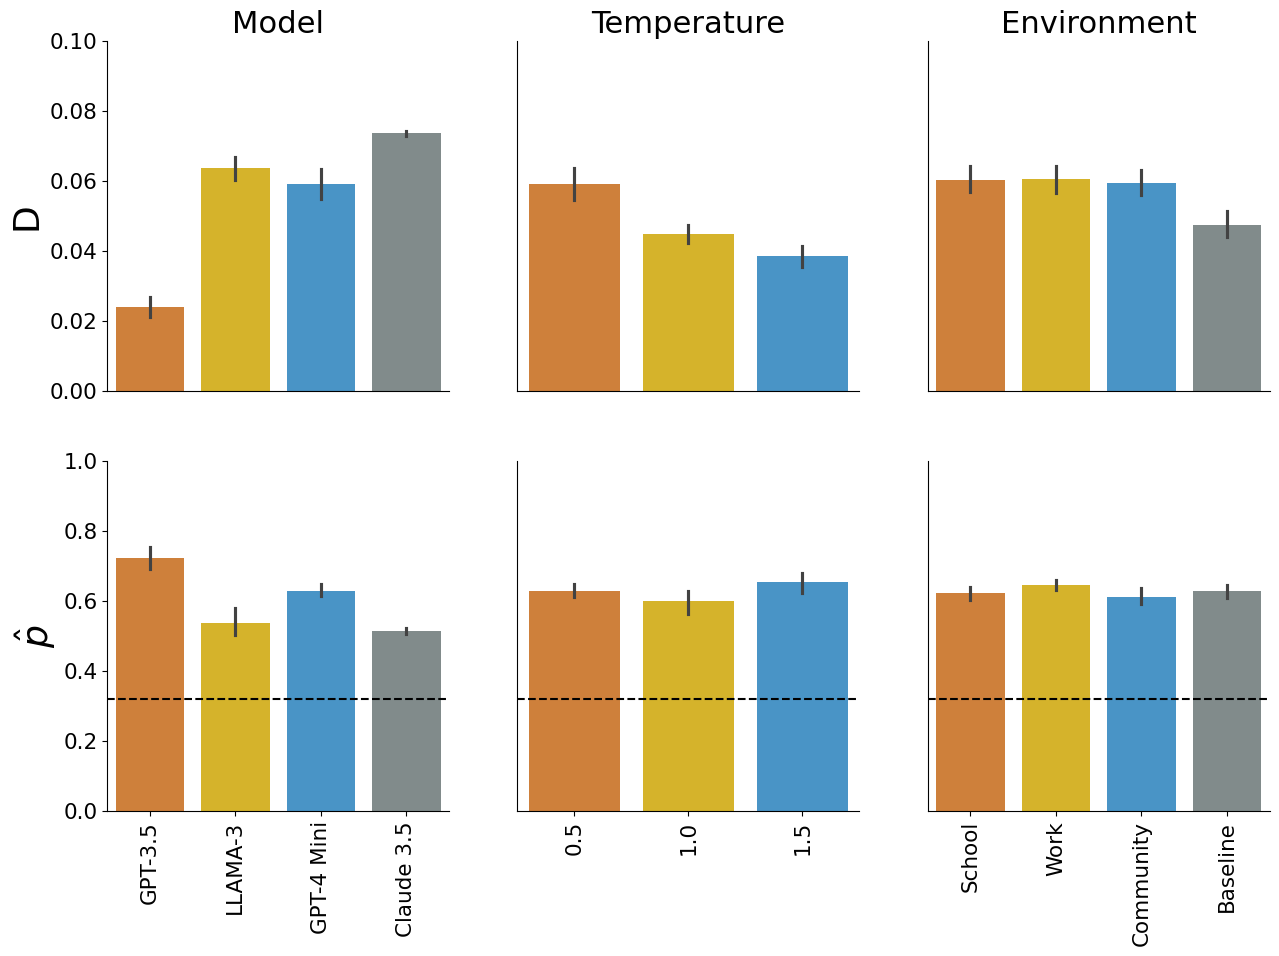

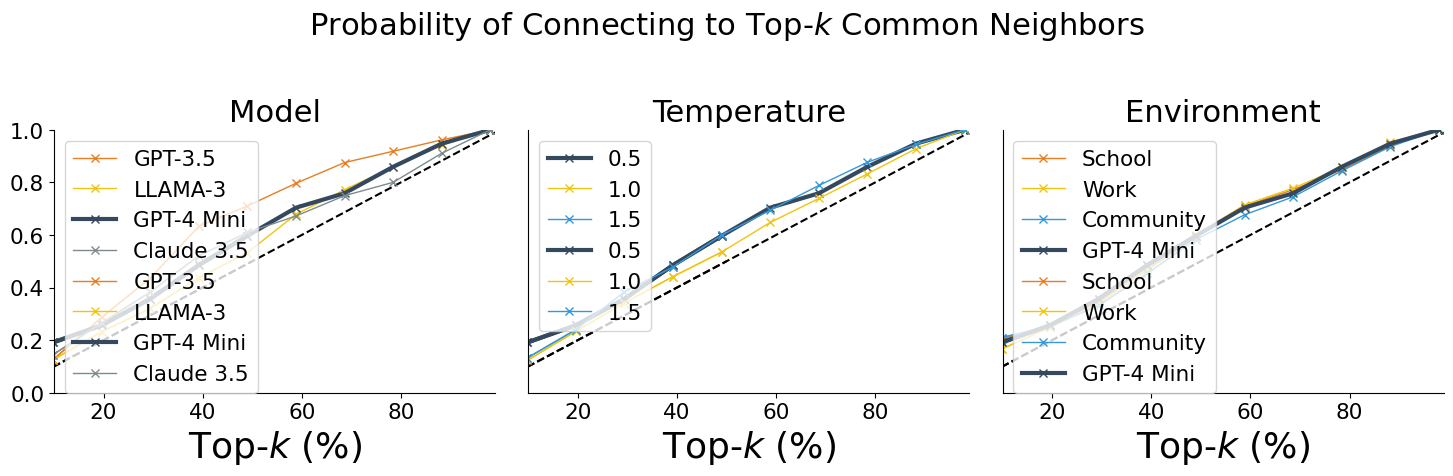

: 

In [ ]:
table_outfiles = []
# Other environments
for environment, role in zip(['school', 'work', 'community'], ['classmates', 'colleagues', 'neighbors']):
    outfile = f'outputs/principle_2_neighbors+gpt-4o-mini+{environment}.jsonl'
    run_network_formation_experiment(50, 50, 1, 10, outfile, [0.5], environment=environment, role=role, method='llm', num_common_neighbors=False, model='gpt-4o-mini')

    table_outfiles.append(outfile)

for model in ['gpt-3.5-turbo', 'meta/meta-llama-3-70b-instruct', 'gpt-4o-mini', 'claude-3-5-sonnet-20240620']:
    outfile = f'outputs/principle_2_neighbors+{model.replace("/", "-")}.jsonl'
    if model == 'claude-3-5-sonnet-20240620':
        run_network_formation_experiment(50, 50, 1, 10, outfile, [0.5, 1.0], method='llm', num_common_neighbors=False, model=model)
    else:
        run_network_formation_experiment(50, 50, 1, 10, outfile, [0.5, 1.0, 1.5], method='llm', num_common_neighbors=False, model=model)

    table_outfiles.append(outfile)

# run_network_formation_experiment(50, 50, 1, 10, 'outputs/principle_2_neighbors.jsonl', [0.5, 1.0, 1.5], method='llm', num_common_neighbors=False)
transitivity_null, probability_null = analyze_experiments('outputs/principle_2_neighbors+gpt-4o-mini.jsonl', num_common_neighbors=False)

# run_network_formation_experiment(50, 50, 1, 10, 'outputs/principle_2.jsonl', [0.5, 1.0, 1.5], method='llm',  num_common_neighbors=True)
# analyze_experiments('outputs/principle_2.jsonl', num_common_neighbors=True)


get_table(table_outfiles, transitivity_null=transitivity_null, probability_null=probability_null)


In [ ]:
table_outfiles_cot = []

# Other environments
for environment, role in zip(['school', 'work', 'community'], ['classmates', 'colleagues', 'neighbors']):
    outfile = f'outputs/principle_2_neighbors+gpt-4o-mini+{environment}_cot.jsonl'
    run_network_formation_experiment(50, 50, 1, 5, outfile, [0.5, 1.0, 1.5], environment=environment, role=role, method='llm', num_common_neighbors=False, model='gpt-4o-mini', cot=True)

    table_outfiles_cot.append(outfile)


for model in ['gpt-3.5-turbo', 'meta/meta-llama-3-70b-instruct', 'gpt-4o-mini', 'claude-3-5-sonnet-20240620']:
    outfile = f'outputs/principle_2_neighbors+{model.replace("/", "-")}_cot.jsonl'

    print(model)

    if model == 'claude-3-5-sonnet-20240620':
        run_network_formation_experiment(50, 50, 1, 5, outfile, [0.5, 1.0], method='llm', num_common_neighbors=False, model=model, cot=True)
    else:
        run_network_formation_experiment(50, 50, 1, 5, outfile, [0.5, 1.0, 1.5], method='llm', num_common_neighbors=False, model=model, cot=True)


    table_outfiles_cot.append(outfile)

get_table(table_outfiles_cot, sfx='_cot')


Skipping simulation for n=50, i=0, temperature=0.5
Skipping simulation for n=50, i=1, temperature=0.5
Skipping simulation for n=50, i=2, temperature=0.5
Skipping simulation for n=50, i=3, temperature=0.5
Skipping simulation for n=50, i=4, temperature=0.5
Skipping simulation for n=50, i=0, temperature=0.5
Skipping simulation for n=50, i=1, temperature=0.5
Skipping simulation for n=50, i=2, temperature=0.5
Skipping simulation for n=50, i=3, temperature=0.5
Skipping simulation for n=50, i=4, temperature=0.5
Skipping simulation for n=50, i=0, temperature=0.5
Skipping simulation for n=50, i=1, temperature=0.5
Skipping simulation for n=50, i=2, temperature=0.5
Skipping simulation for n=50, i=3, temperature=0.5
Skipping simulation for n=50, i=4, temperature=0.5
Skipping simulation for n=50, i=0, temperature=0.5
Skipping simulation for n=50, i=0, temperature=1.0
Skipping simulation for n=50, i=0, temperature=1.5
Skipping simulation for n=50, i=1, temperature=0.5
Skipping simulation for n=50, i

/Users/marios/miniconda3/lib/python3.12/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


Transitivity null:  0.021528656752780748
Transitivity T-test (50, 0.5) random TtestResult(statistic=np.float64(13.93688118541773), pvalue=np.float64(2.0187982648075973e-06), df=np.float64(7.109338458636611))
Transitivity T-test (50, 1.0) random TtestResult(statistic=np.float64(13.007780810458154), pvalue=np.float64(2.73408605135538e-05), df=np.float64(5.4135063709257025))
Transitivity T-test (50, 1.5) random TtestResult(statistic=np.float64(8.807556717051622), pvalue=np.float64(0.00035402090001861224), df=np.float64(4.8803187129928265))
Algebraic Connectivity T-test (50, 0.5) random TtestResult(statistic=np.float64(-2.1410715534791884), pvalue=np.float64(0.0934112461737587), df=np.float64(4.351490723047432))
Algebraic Connectivity T-test (50, 1.0) random TtestResult(statistic=np.float64(-1.6717335562357098), pvalue=np.float64(0.1552033509570653), df=np.float64(5.020223166187589))
Algebraic Connectivity T-test (50, 1.5) random TtestResult(statistic=np.float64(0.45720472148098884), pvalu

/Users/marios/miniconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


outputs/principle_2_neighbors_er+gpt-4o-mini+school.jsonl
outputs/principle_2_neighbors_er+gpt-4o-mini+work.jsonl
outputs/principle_2_neighbors_er+gpt-4o-mini+community.jsonl
outputs/principle_2_neighbors_er+gpt-3.5-turbo.jsonl
outputs/principle_2_neighbors_er+meta-meta-llama-3-70b-instruct.jsonl
outputs/principle_2_neighbors_er+gpt-4o-mini.jsonl
outputs/principle_2_neighbors_er+claude-3-5-sonnet-20240620.jsonl


/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_37586/2747599785.py:709: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sc_model = sns.barplot(data=df_model, y='Marginal Transitivity', x='Model', ax=ax[0, 0], palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9'])
/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_37586/2747599785.py:709: UserWarning: The palette list has more values (7) than needed (4), which may not be intended.
  sc_model = sns.barplot(data=df_model, y='Marginal Transitivity', x='Model', ax=ax[0, 0], palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9'])
/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_37586/2747599785.py:711: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the

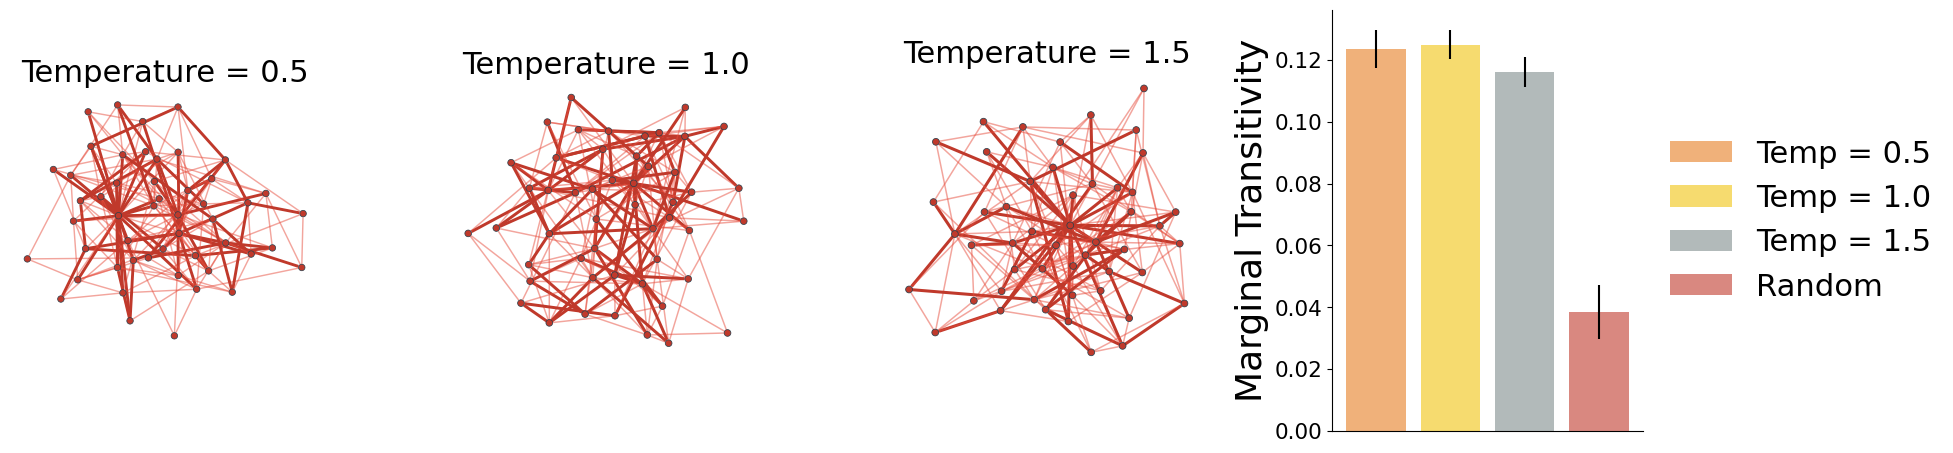

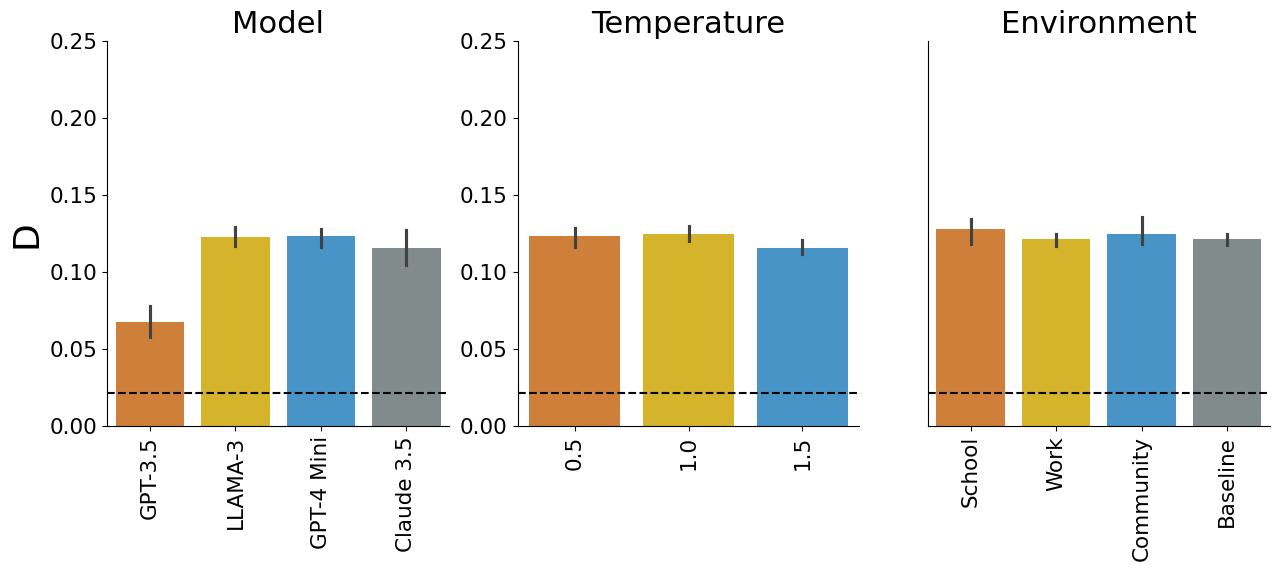

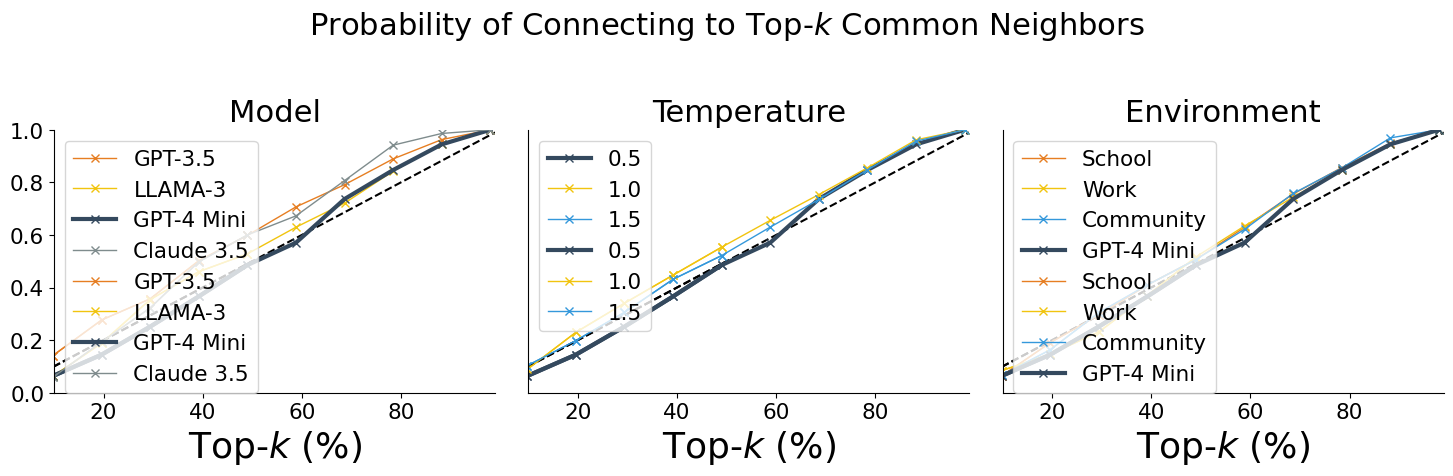

: 

In [ ]:
table_outfiles_er = []
# Other environments
for environment, role in zip(['school', 'work', 'community'], ['classmates', 'colleagues', 'neighbors']):
    outfile = f'outputs/principle_2_neighbors_er+gpt-4o-mini+{environment}.jsonl'
    run_network_formation_experiment(50, 50, 1, 5, outfile, [0.5], environment=environment, role=role, method='llm', num_common_neighbors=False, model='gpt-4o-mini', er=True)

    table_outfiles_er.append(outfile)

# for model in ['meta/meta-llama-3-70b-instruct']:

for model in ['gpt-3.5-turbo', 'meta/meta-llama-3-70b-instruct', 'gpt-4o-mini', 'claude-3-5-sonnet-20240620']:

    outfile = f'outputs/principle_2_neighbors_er+{model.replace("/", "-")}.jsonl'
    if model == 'claude-3-5-sonnet-20240620':
        run_network_formation_experiment(50, 50, 1, 5, outfile, [0.5, 1.0], method='llm', num_common_neighbors=False, model=model, er=True)
    else:
        run_network_formation_experiment(50, 50, 1, 5, outfile, [0.5, 1.0, 1.5], method='llm', num_common_neighbors=False, model=model, er=True)

    table_outfiles_er.append(outfile)

transitivity_null, probability_null = analyze_experiments('outputs/principle_2_neighbors_er+gpt-4o-mini.jsonl', num_common_neighbors=False, er=True, sfx='_er')

get_table(table_outfiles_er, transitivity_null=transitivity_null, probability_null=probability_null, er=True, sfx='_er')
